<h1 align="center"> Statistics and Financial Data Science </h1>




GARCH examples
===

In [1]:
%reset -f

In [2]:
#import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm
import pandas_datareader as pd_data

In [3]:
# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sm_tools

In [50]:
# ! pip install pmdarima
# ! pip install arch

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from datetime import datetime
# For splines
import patsy
from patsy import dmatrix
from arch import arch_model
from arch.univariate import ARX
from arch.univariate import GARCH
import pandas_datareader.data as web
import datetime as dt
import scipy.stats as st

In [6]:
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:

def plot_diagnosticsTight3(data,df=0):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))

    ax1.hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Data")

    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")

    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True,auto_ylims=True)
    ax3.grid()

    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,model_df=df)#package version

    ax4.plot(ljbox_test['lb_pvalue'])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()

    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()

    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")

    plt.tight_layout()

In [8]:
import yfinance as yfin
yfin.pdr_override()
start_date = '2007-01-01'
end_date = '2022-01-01'

AAPL = pd_data.data.get_data_yahoo('AAPL', start_date,end_date)
AAPL.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,177.089996,180.419998,177.070007,180.330002,178.292892,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.264603,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,177.353638,62348900
2021-12-30,179.470001,180.570007,178.089996,178.199997,176.186920,59773000
2021-12-31,178.089996,179.229996,177.259995,177.570007,175.564056,64062300


In [9]:
# Let's look at the returns
AAPLRet = np.log(AAPL['Adj Close']).diff().dropna()
AAPLRet.head()

Date
2007-01-04    0.021953
2007-01-05   -0.007147
2007-01-08    0.004927
2007-01-09    0.079799
2007-01-10    0.046746
Name: Adj Close, dtype: float64

1) Plot ACF/PACF for first impression on autoregressive features

2) Test for stationarity (otherwise transform)

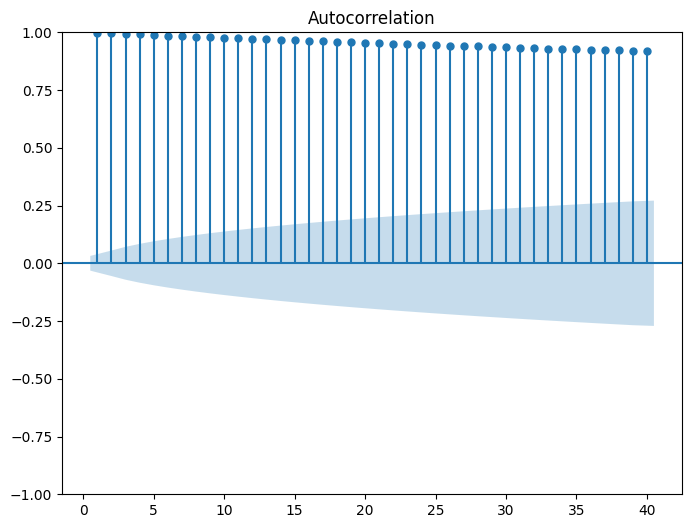

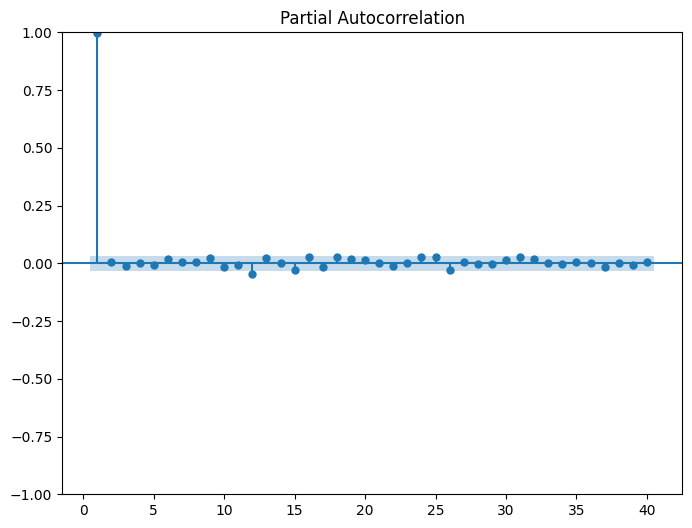

In [179]:
plot_acf(AAPL['Adj Close'],zero = False, lags = 40);
plot_pacf(AAPL['Adj Close'], zero = False, lags =40);
plt.show()

In [15]:
# Existence of Unit Root
test = adfuller(AAPL['Adj Close'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: 4.099029
p-value: 1.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [16]:
# Kpss test rejects stationarity
test = kpss(AAPL['Adj Close'])
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 6.719110
p-value: 0.010000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


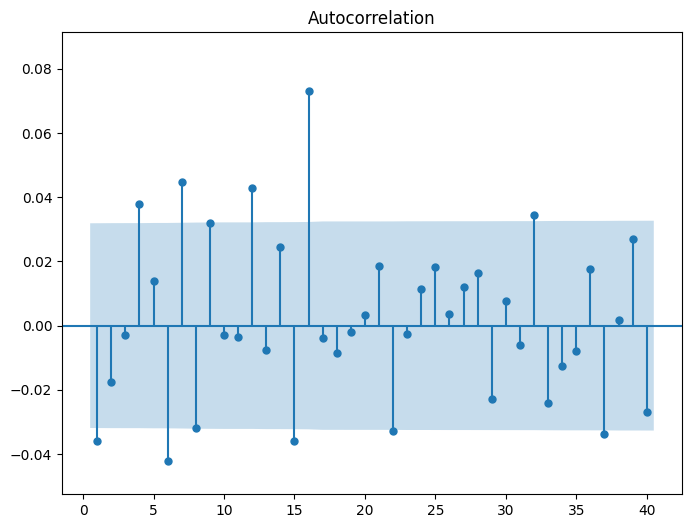

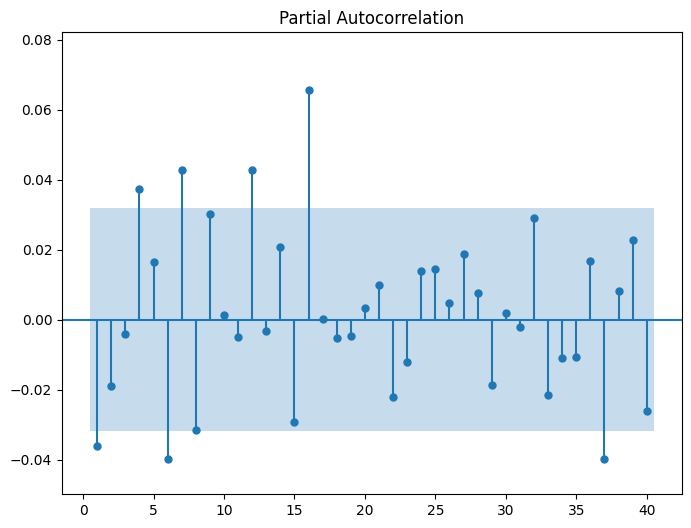

In [11]:
plot_acf(AAPLRet,zero = False, lags = 40,auto_ylims=True);
plot_pacf(AAPLRet, zero = False, lags =40,auto_ylims=True);
plt.show()

Data passes the stationarity tests - I can consider modelling as an ARMA process
===

In [12]:
# Reject Unit Root
test = adfuller(AAPLRet)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -13.815719
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [13]:
# Kpss test supports stationarity
test = kpss(AAPLRet)
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.063946
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


3) Find / fit best ARMA model (already differenced once).

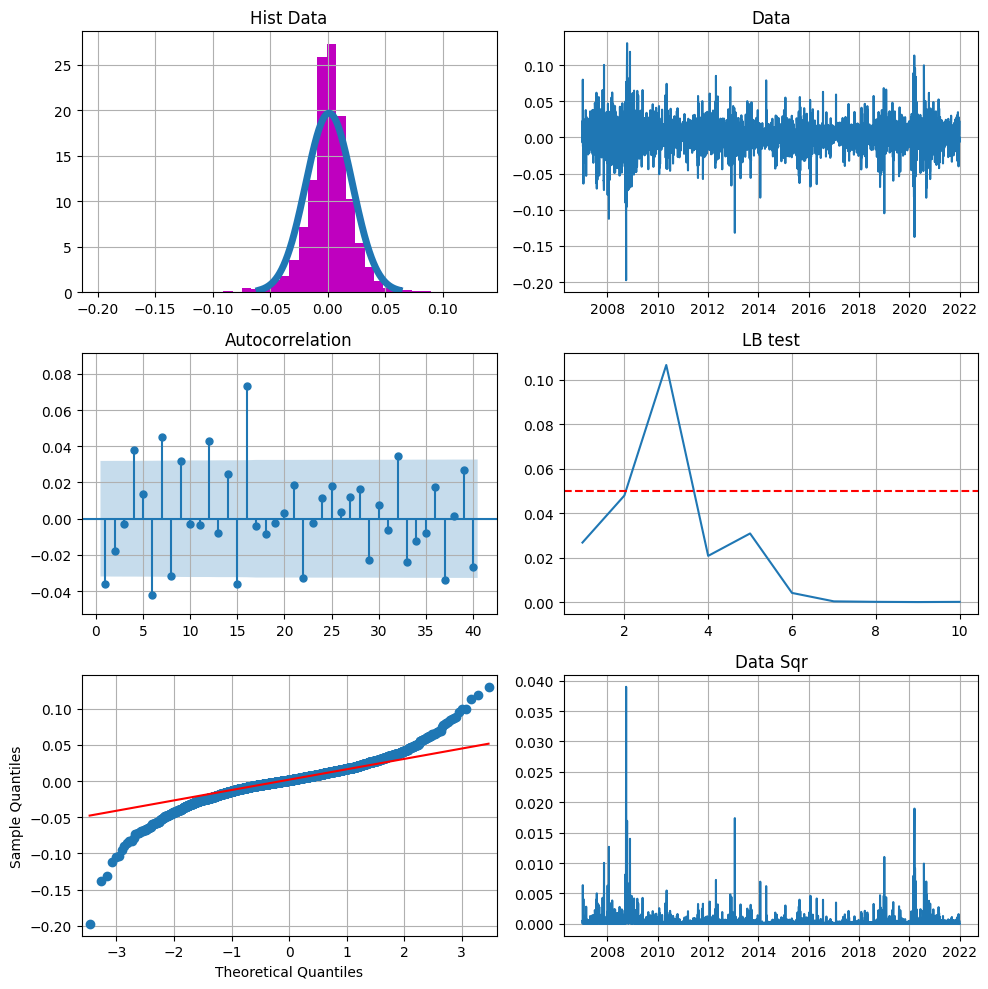

In [20]:
# Just plotting graphs on the actual data and examining the results fo the Ljung-Box test...
# I see that there is auto-correlation

plot_diagnosticsTight3(AAPLRet)

In [18]:
# So can fit an ARMA type model
results = pm.auto_arima(AAPLRet, trace = True, seasonal=False,
                        stationary = True, stepwise = False,with_intercept=True,
                        information_criterion='aic', start_q=0, max_p = 6, max_q = 1,d=0)
# Order selected is given in summary
print(results.summary())
# This chooses AR 4 model for the mean

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-18725.242, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-18728.327, Time=1.39 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-18728.142, Time=0.72 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-18725.750, Time=3.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-18727.496, Time=2.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-18725.132, Time=0.84 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-18725.559, Time=1.42 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-18723.537, Time=1.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-18728.875, Time=1.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-18726.957, Time=2.23 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-18727.929, Time=3.21 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 17.742 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3776
Model:          

In [1]:
?pm.auto_arima

Object `pm.auto_arima` not found.


In [22]:
model = sm.tsa.SARIMAX(AAPLRet, trend='c',order=(4, 0, 0))
fit = model.fit(disp = False)
print(fit.summary());

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3776
Model:               SARIMAX(4, 0, 0)   Log Likelihood                9370.438
Date:                Thu, 16 Nov 2023   AIC                         -18728.875
Time:                        02:43:59   BIC                         -18691.457
Sample:                             0   HQIC                        -18715.573
                               - 3776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.000      3.328      0.001       0.000       0.002
ar.L1         -0.0367      0.010     -3.720      0.000      -0.056      -0.017
ar.L2         -0.0180      0.011     -1.701      0.0

4) Plot Diagnostics on residuals of the model

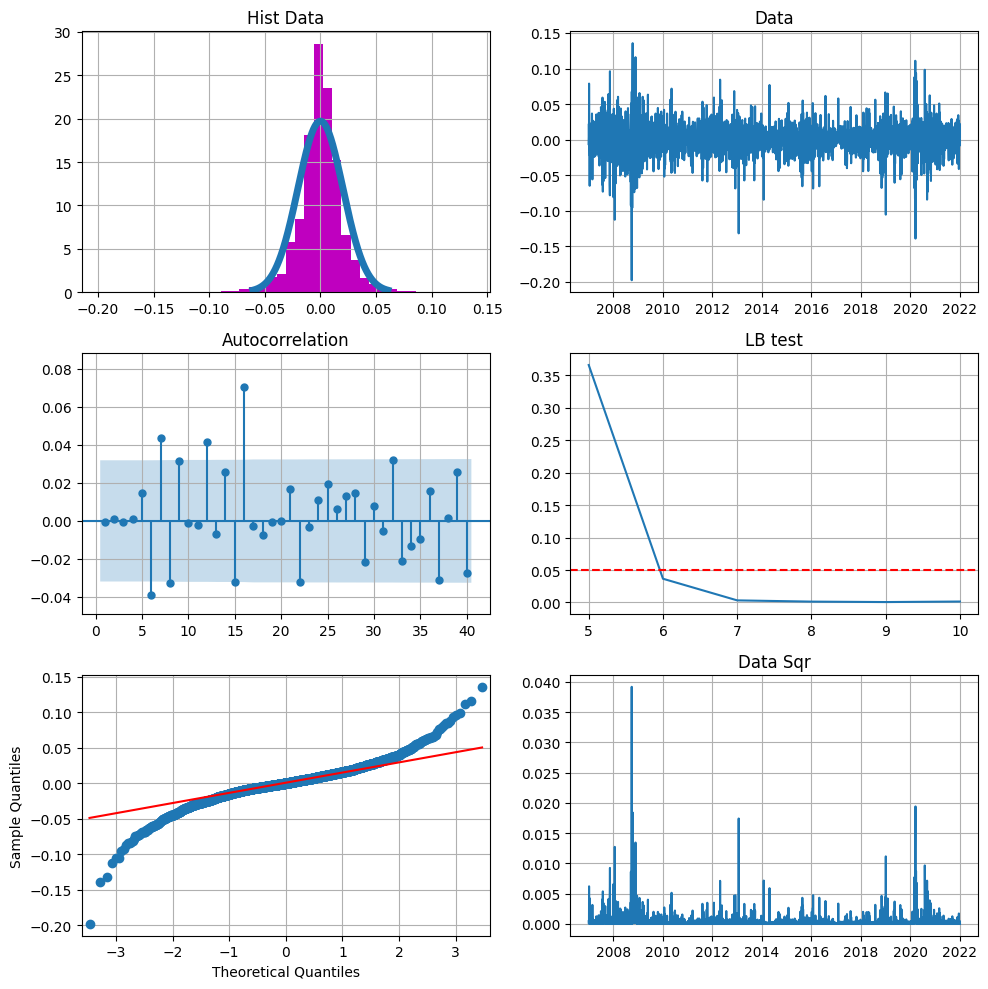

In [23]:
plot_diagnosticsTight3(fit.resid,4)

There is no auto-correlation and residuals do not pass the Ljung-Box test, there also seem to be clusters
in the data and also the QQ plot does not fit with normality. There could be due to heteroskedasticity - so we examine
the squared residulas

5) Check squared residuals ACF/PACF - these indicate some AR with order maybe 5 - 9, depending on how complex we wish model to be.

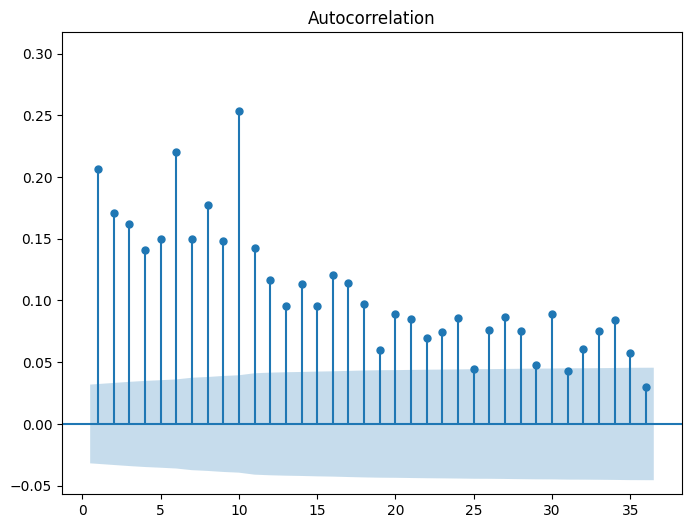

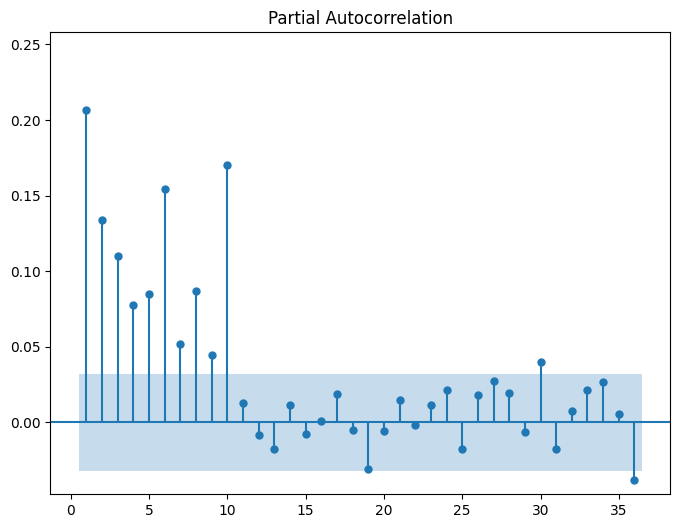

In [25]:
plot_acf(fit.resid**2, zero = False,auto_ylims=True);
plot_pacf(fit.resid**2, zero = False,auto_ylims=True);

plt.show()

In [ ]:
# Above were examples with SARIMAX which are familiar with. In arch_model we need to
# specify a mean model using a different method - this is restricted to AR type only, with
# potential external regressors.

6) Combine the models by specifying the mean and vol processes into a GARCH model:

In [28]:
# The model allows us to choose specific lags - this is very similar to the SARIMAX function from statsmodels:
# Diff are possibly due to numerical approx / methods/ tolerance
from arch.univariate import ARX

arx = ARX(AAPLRet, lags= 4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(4,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9583.298788829215
            Iterations: 15
            Function evaluations: 202
            Gradient evaluations: 11
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.002
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                       ARCH   Log-Likelihood:                9583.30
Distribution:                  Normal   AIC:                          -19146.6
Method:            Maximum Likelihood   BIC:                          -19084.2
                                        No. Observations:                 3772
Date:                Thu, Nov 16 2023   Df Residuals:                     3767
Time:                        02:52:50   Df Model:                            5
                                   Mean Model                                 

- I'm suspiscious on the convergence of the model as all alphas are the same.
- We can try using the rescale function to see if we obtain an improvement or
- We can try to scale the returns (by x 100)... let's try both and watch the effect on coefficients

In [29]:
arx = ARX(AAPLRet, lags= 4,rescale = True) #this is eq. to AR(4) as per above
arx.volatility = GARCH(4,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7638.755566561721
            Iterations: 22
            Function evaluations: 271
            Gradient evaluations: 22
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.009
Mean Model:                        AR   Adj. R-squared:                 -0.010
Vol Model:                       ARCH   Log-Likelihood:               -7638.76
Distribution:                  Normal   AIC:                           15297.5
Method:            Maximum Likelihood   BIC:                           15359.9
                                        No. Observations:                 3772
Date:                Thu, Nov 16 2023   Df Residuals:                     3767
Time:                        02:55:14   Df Model:                            5
                                   Mean Model                                  

In [30]:
newAAPLRet =AAPLRet*100
arx = ARX(newAAPLRet, lags=4,rescale = False) #this is eq. to AR(4) as per above
arx.volatility = GARCH(4,0,0)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7638.755566561721
            Iterations: 22
            Function evaluations: 271
            Gradient evaluations: 22
                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                      -0.009
Mean Model:                        AR   Adj. R-squared:                 -0.010
Vol Model:                       ARCH   Log-Likelihood:               -7638.76
Distribution:                  Normal   AIC:                           15297.5
Method:            Maximum Likelihood   BIC:                           15359.9
                                        No. Observations:                 3772
Date:                Thu, Nov 16 2023   Df Residuals:                     3767
Time:                        02:55:56   Df Model:                            5
                                   Mean Model                                  

Try different GARCH models, GARCH(1,1) gives the lowest AIC.

In [32]:
arx = ARX(AAPLRet, lags= 4,rescale = True) #this is eq. to AR(4) as per above
arx.volatility = GARCH(1,0,1)
res = arx.fit(update_freq=0)#, tol=0.000001
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7523.744870927528
            Iterations: 14
            Function evaluations: 153
            Gradient evaluations: 14
                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                      -0.002
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -7523.74
Distribution:                  Normal   AIC:                           15063.5
Method:            Maximum Likelihood   BIC:                           15113.4
                                        No. Observations:                 3772
Date:                Thu, Nov 16 2023   Df Residuals:                     3767
Time:                        03:02:20   Df Model:                            5
                                   Mean Model                                  

7) Analyse outputs and consider diagnostics of model

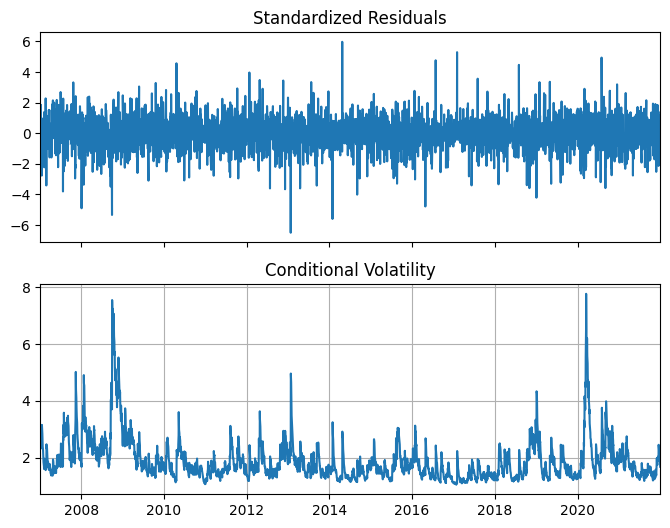

In [37]:
# Exploring the outputs
res.plot()
plt.grid()
plt.show()

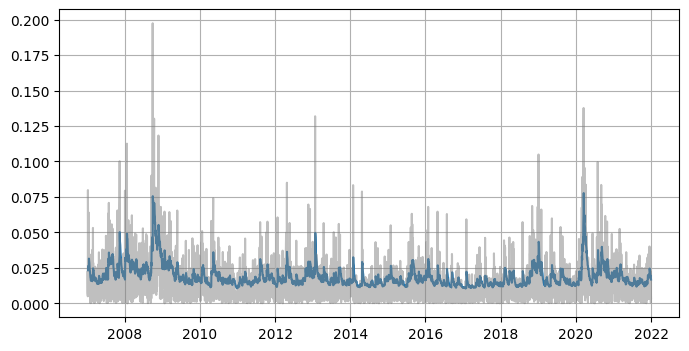

In [40]:
# Plot conditional vol vs abs(ret)
plt.figure(1, figsize=(8,4))
plt.plot(res.conditional_volatility/100) # just a rescale
plt.plot(abs(AAPLRet), color = 'grey', alpha = 0.5)
plt.grid()
plt.show()

7) Consider Diagnostics of StdResiduals: Ljung-Box tests to verify no autocorrelation and normality tests

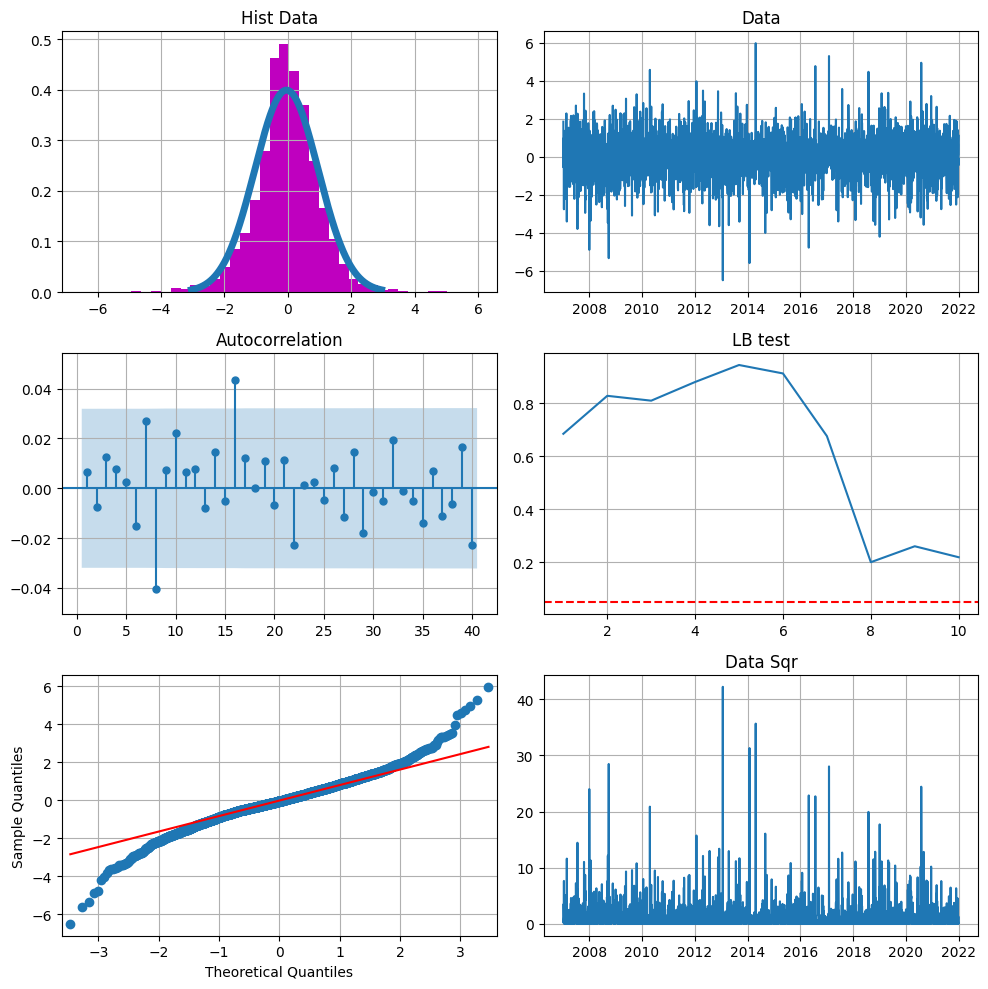

In [36]:
std_resid = res.resid/res.conditional_volatility
std_resid = std_resid.dropna()
plot_diagnosticsTight3(std_resid)

- The standardized residuals have passed the Ljung-Box test, supporting the case that they are white noise
- However, the QQ plot still does not seem to fit a normal, potentially a different distribution shoudl be considered.
- We should verify by formal normality tests: both reject hypothesis of normality.

In [41]:
JB_test = stats.jarque_bera(std_resid)
print('Jarque-Bera statitiscs: ', JB_test[0])
print('Jarque-Bera p-value: ', JB_test[1])

Jarque-Bera statitiscs:  1322.4110228965922
Jarque-Bera p-value:  6.951763260803393e-288


In [42]:
shap_test = stats.shapiro(std_resid)
print('Shapiro statitiscs: ', shap_test[0])
print('Shapiro p-value: ', shap_test[1])

Shapiro statitiscs:  0.9734292030334473
Shapiro p-value:  6.251361523493347e-26
